# Bootstrapping

In the following, we explain and analyse the properties of bootstrapping methods.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn

from pandas import Series
from pandas import DataFrame

from tqdm.notebook import trange
from sklearn.linear_model import LogisticRegression
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Experiment setup

We again consider a relatively simple prediction task with a relatively small feature set and an impossible prediction task with the same feature set for comparison. 
We use majority voting and logistic regression as example classifiers like in the previous notebook. 

In [2]:
sampler_0 = lambda n: data_sampler(n, 8, lambda x: logit(x, Series([0, 0])))
sampler_1 = lambda n: data_sampler(n, 8, lambda x: logit(x, Series([1, 1])))
clf_1 = MajorityVoting()
clf_2 = LogisticRegression(solver = 'lbfgs')

## II. Naive bootstrap method

The simplest application of bootstrap principle is to sample $B$ bootstap samples $\mathcal{Z}_b$, i.e. sample $B$ times from the set $\{(\boldsymbol{x}_1, y_1),\ldots (\boldsymbol{x}_N, y_N)\}$ with replacement. For each of these samples $\mathcal{Z}_b$, we can compute the empirical risk estimator on the entire dataset:
\begin{align*}
E_b=\frac{1}{B}\cdot\sum_{b=1}^B\frac{1}{N}\cdot\sum_{i=1}^N  L(y_i, f_b(\boldsymbol{x}_i)),
\end{align*}
where $f_b(\boldsymbol{x_i})$ is the prediction for $\boldsymbol{x}_i$ trained on $\mathcal{Z}_b$.
This naive bootstrap estimate on the test error will be too optimistic as we estimate the risk on the set of data that is some weird mixture of training and test samples.

## III. Leave-one-out bootstrap method

It is possible to modify the leave-one-out cross-validation scheme such that the training set is not $n-1$ elements but rather a bootstrap sample over these $n-1$ elements. Formally, this requires us to define $n$ different bootstrap distributions but we can do simple rejection sampling. We sample $B$ times from the set $\{(\boldsymbol{x}_1, y_1),\ldots (\boldsymbol{x}_N, y_N)\}$ with replacement and reject cases where $(\boldsymbol{x}_i, y_i)$ is inside the sample. This leads to the following error estimate:
\begin{align*}
E_b^*=\frac{1}{N}\cdot\sum_{i=1}^N \frac{1}{|C_i|}\cdot \sum_{b\in C_i} L(y_i, f_b(\boldsymbol{x}_i)),
\end{align*}
where $C_i$ is the set of indices $b$ such that the bootstrap sample $\mathcal{Z}_b$ does not contain $(\boldsymbol{x}_i, y_i)$ and $f_b(\boldsymbol{x_i})$ is the corresponding prediction for $\boldsymbol{x}_i$ trained on $\mathcal{Z}_b$.



## IV. .632 bootstrap method

The leave-one-out bootstrap estimate $E_b^*$ is too conservative as the predictor is trained on the training set which on average consists of a fraction $0.632$ different datapoints from the available sample. 
The training error
\begin{align*}
E_t = \frac{1}{N}\cdot\sum_{i=1}^N L(y_i, f(\boldsymbol{x}_i)),
\end{align*}
where $f_b(\boldsymbol{x}_i)$ is a predictor for $\boldsymbol{x}_i$ trained on the entire dataset, is too optimistic.
The average 

\begin{align*}
E_{.632}= 0.632\cdot E_b^* + 0.368\cdot E_t 
\end{align*}

is a reasonable trade-off between both estimates. This is called the .632 bootstrap method.

## V. .632+ bootstrap method

The .632 bootstrap method works rather nicely, except for the cases where the training error $E_t$ is zero or close to zero due to overfitting. 
To counter this issue, we can define a correction by estimating the relative overfitting rate
\begin{align*}
R=\frac{E_b^*-E_t}{\gamma- E_t},
\end{align*}
where 
\begin{align*}
\gamma = \frac{1}{N^2}\cdot\sum_{i=1}^N \sum_{j=1}^N L(y_i, f(\boldsymbol{x}_j))
\end{align*}
is the expected loss when we predict $y_i$ based on randomly chosen $\vec{x}_j$ value using the predictor $f$ trained on the entire dataset.

From the overfitting rate we can compute modified weights for combining the errors
\begin{align*}
E_{.632+}=w\cdot E_b^*+ (1-w)\cdot E_t,
\end{align*}
where 
\begin{align*}
w=\frac{0.632}{1-0.368\cdot R}.
\end{align*}

Note that when there is no overfitting ($E_b^*=E_t$), then the .632+ bootstrap estimate is the same as the .632 estimate.

# Homework

## 9.1 Comparison of bootstrap methods (<font color='red'>2p</font>)

Implement the basic bootstrapping algorithm which draws $n$ samples randomly with replacement from an $n$-element dataset.
You can use `DataFrame.sample(n, replace=True)` for that. On top of that, implement all the bootstrap estimates and compare their behaviour on four example cases:
* For each data source and algorithm pair, draw around 1000 datasets of size 100.
* For each of these datasets, compute $E_b, E_b^*, E_t, E_{.632}, E_{.632+}$.
* For each of these datasets, also sample an $n$-element independent test set and compute the hold-out error $E_h$.
* Visualise the results by drawing violin plots and boxplots.
* Interpret the results. Which of those estimates is closest to $E_h$? Why some estimates are biased?

## 9.2 Analysis of prediction stability (<font color='red'>3p</font>)

Bootstrapping can be used to study the stability of a learning algorithm:

* You can study how much the coefficients of your model vary.
* You can study how fragile is your learning algorithm to noise.

Let's explore these concepts by studying the stability of polynomial regression models $y\sim x^2+x+1$ and $y\sim x^8 + x^7 + \cdots + x + 1$.

* Stability of coefficients (<font color='red'>1p</font>) 
  * Fit these models on bootstrapped data and observe regression coefficients by drawing corresponding boxplots. 
  * Study the mean and variance of individual model coefficients. Declare that a coefficient is insignificant and set it to zero when its mean is not more than 3 standard deviations away from zero. 
  * Interpret the results. Are both models similar?
  
  
* Stability of predictions (<font color='red'>1p</font>) 
  * Fit these models on bootstrapped data.
  * For each learned model, compute a prediction line in the interval $[-2,1]$.
  * Draw a faceted plot with facets for models $y\sim x^2+x+1$ and $y\sim x^8 + x^7 + \cdots + x + 1$.
  * On each subplot, plot individual prediction lines. Use `alpha=0.5` to make lines semi-transparent.
  * Draw also the average prediction line in red on the plot.


* Stability against noise (<font color='red'>1p</font>) 
  * To study robustness against noise, you can add additional Gaussian noise to $y_i$ values of bootstrapped samples     and later estimate how much the mean squared error increased as a consequence. 
  * The latter should estimate how sensitive is your method to random noise.
  * Experiment with different scale values $\sigma=0.001, 0.01, 0.1, 1$, and visualise the results.
 
  

### Remarks
* Use the sampler `regr_sampler` as the data source. 
* Use [sklearn.linear_model.LinearRegression](
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) together with 
[sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to implement polynomial regression:
  * First define additional columns $x_2=x^2, \ldots, x_8=x^8$.
  * Then use linear regression to find corresponding coefficients $\beta_0,\beta_1,\ldots, \beta_8$.
* Use [numpy.random.normal](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) to sample the additional Gaussian noise needed in the last part of the exercise.

In [3]:
def regr_sampler(n: int) -> DataFrame:
    return (DataFrame(np.random.uniform(low=-2, high=1, size=n), columns=['x']).
            assign(y = lambda df: df['x']**2 + df['x'] + np.random.normal(scale=0.3, size=len(df))))        

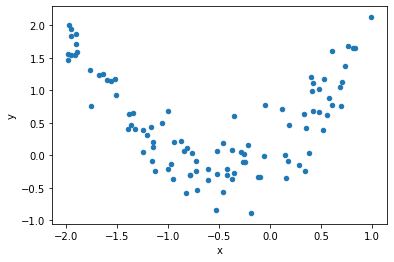

In [4]:
regr_sampler(100).plot(x = 'x', y = 'y', kind='scatter')

## 9.3 Bootstrap and its reduction to Monte Carlo cross-validation* (<font color='red'>3p</font>)

Note that the same datapoint can occur many times in a bootstrap sample. 
This does not play nicely with methods that ignore the sample count in training, such as Support Vector Machines that fix the decision border based on the support vectors alone. Study this phenomenon by considering a simple linear classification task. Compute leave-one-out bootstrap estimate $E_b^*$ and compare it with error estimate $E_{mc}$ of Monte Carlo cross-validation scheme with a ratio $0.632:0.368$ between training and test set.

* Do both methods obtain the same average error estimate? 
* If not, which of them is closer to the true test error for the model trained over the entire dataset?
* Estimate the variances of $E_b^*$ and $E_{mc}$. Are they comparable?
* Is there a difference if you consider a hard SVM that ignores multiplicity and soft SVM that considers multiplicity through hinge loss? 

In [5]:
%config IPCompleter.greedy=True